## Description:
######Model type = LSTM
######Hidden layers = 128*2
######train seq_len = 200
######model id = rnn1024-200, misuse, actually lstm 128 2 200
######the rec is overwrite by true rnn1024-200, but lstm128-200 is similar




In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [0]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Data Loading

In [0]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 200
batch_size = 50
#model:
hidden_size = 128
n_layers = 2
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "rnn1024-200" #save as , wtf 128
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Preprocessing Data

In [0]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

432 torch.Size([201, 50])
22 torch.Size([201, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=seq_len, device='cpu'): #npttext, 200 #0,300 #can use param to set random = True 
    #l = np.random.randint(0, len(data)-seq_len-2)
    l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)
    
    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [0]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.011060000397264957
test random train seq
----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
xAnIkO.vXghDp.sJFnDG

gFGgngzsoH]JHsJpp-yZ
-KDMo$nyxoZogkMgSgVg;ynJH[J$oioongCtDsqloyGosCctx]k$G
nYydsoyJMCuHrGggCCHDVCY
.pJg[UiNXnCyxyo]DunGRCnwyM
soJ-gCOCJCNGCxSs
xMDxy!DtoJgCXyxOaUgSOMS$RiDINAyHong
test generate with forwardc
JulietoInnnnnhngxtoooHRNva
ytoy]hnhnhnCmRnnnnnnnnyxCPEe$
Q]d]gUqXheNvYgytoV Hg[J$
x]Mgx]gxq.HHooHbNy.oNld]gimOyoHRNDdCy.HINS!h-AgCkzovitoyMMgx!
JaVaUB-LtyMg 

testing lstm model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 128]) torch.Size([2, 50, 128])
test forwardc
torch.Size([67]) torch.Size([

Train

Build new model

In [0]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=seq_len, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [0]:
train()

  0%|          | 0/432 [00:00<?, ?it/s, loss=2.885, test_ac=0.255, train_ac=0.247]


At 1 epoche, loss = 3.358, train ac = 0.147, test ac = 0.148
RNN write with seed Juliet

##############################

Juliet oy heos e.,Fz foo or 
te yseetlen eore oo, Relt wror td-ee rwoe ead sain tthr el hioise go ot aened arashL mn gsmeee
 ame roan seehe igll Qnins itod 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


 
oo  





 hee n te the to   ho ao    hoen to  
he  te te e   to ae  hhe   hoee  n     
he teee     ten toee    ho  to oee 


en hoheen tt nn  he hen teoe n  toe   
h he hoe  te   te aen ton  the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.485, test_ac=0.310, train_ac=0.302]


At 2 epoche, loss = 2.685, train ac = 0.281, test ac = 0.288
RNN write with seed Juliet

##############################

Juliet matale imes:
kmet,. A shuncide, wa as ont
Ite ti,y,
sh he tsou-red

the fipiy de yecamsunl hash thhe as lige evatve the suinthe mantove havecs lyersr

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------




I 
:



I  tet nete the torr tr tore  toan tr  
one te treoreetr tn  then  tonee n n   
he tnee  n  ten tone    tnd torton 

hen tohenn tnenn  tn ten tntoen  tone 

  tn tone tr   te trnetone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.301, test_ac=0.361, train_ac=0.352]


At 3 epoche, loss = 2.393, train ac = 0.329, test ac = 0.334
RNN write with seed Juliet

##############################

Juliet, I coun, yinon peller whesd son th hdoreir os or.

SOREIE:
Lhe
Dets me want, cosges con, some
As cony arse hary thar and waine manach sirdh: not way 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------




I :::::
T  tet nhhe the torr tn tore  toot tn  Tone te tnaortetn tn  thet  totee n ne  The tneer nh ten tone    tnd toutons

het toeetn tnhnn 
tn tet tntoond torl 
T  tn tone tns  te tnnetote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.205, test_ac=0.373, train_ac=0.369]


At 4 epoche, loss = 2.279, train ac = 0.355, test ac = 0.371
RNN write with seed Juliet

##############################

Juliet, sunthen, or oa the solls me hou bat bishemendiring dut.

Gor
Adist ut minones sall till, mast undeven and
yore thut mulan he mantefrut, and du'fer ,

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 
 
I :::::
T  tettnete the torr tf tore  toot tf  Tote te tntortetf tn  thet  totee n ng  The tneer nh ten tone s  tnd to tons

het toeetn tnenn 
tn tet tntoong torl 
T  tn tone tfs  te tnnetote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.157, test_ac=0.412, train_ac=0.379]


At 5 epoche, loss = 2.203, train ac = 0.378, test ac = 0.388
RNN write with seed Juliet

##############################

Julieteus:.

TELOUM:
Wend last pat
Wous an my wit the noust secar's your
And Go ournom fadepien harve; you maI
As beind that mis hether me woh of srountes p

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :  I  ::::
T  tettnete the torr tf tore  trot tf  Tote te tntortetf tn  thet  three n ng  The tneer ne ten tone r  tnd to tens

het theenn tnenn 
In tet tnto ng torl 
T  tn tone tfs  te tnr tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.049, test_ac=0.406, train_ac=0.403]


At 6 epoche, loss = 2.119, train ac = 0.392, test ac = 0.401
RNN write with seed Juliet

##############################

Juliety wreath bey cange bught pnoksen,
And by be peat
He wall or the't heart womiV, you warl heapse sturfed coventer, aver.
Whou stremenk premarwoth hole.


##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :  I  :N::
T  testnete the torr tf tore  trot tf  Tote te tntorteaf tn  thet  three nhng  The tneer ne ten tone d  tnd to tens

het thaenn tnenn 
In tet tnto ng torl 
T  tn tone tfs  te tnrstote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.164, test_ac=0.422, train_ac=0.369]


At 7 epoche, loss = 2.054, train ac = 0.409, test ac = 0.413
RNN write with seed Juliet

##############################

Julieter wet cilly, cing as the realsed fars? I porthipser her and and bele, in man the there,
Serone he ment, ham hould hord,
O but and 'igs loth,
Bto your

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S :I  :NA:
W  testnete the torr tf tore  aran tf  Tote te tntorteaf tn  ahet  three n eg  The tneer ne ten tone r  tnd th tens

het thaenn tnenn  In tet tnto ng torl 
Tn tn tone tf r te tnrstote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.039, test_ac=0.439, train_ac=0.416]


At 8 epoche, loss = 2.037, train ac = 0.411, test ac = 0.418
RNN write with seed Juliet

##############################

Juliety:
Won enk leauth with thach is,
Be thoe walt thou the one freat ere, the not the prave,
anwond the, pories.

BDRALO:
A that misale ra she qhatriws a 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S :I   N::
W  testnhte the torl tf tore  arai tf  Aote te tntortetf tn  thet  threenn og  The tneer ne ten tone r  tnd th tens

het thaann tnenn  In tev tntoong torl 
T  tn tone tf r te tnrttote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.934, test_ac=0.450, train_ac=0.436]


At 9 epoche, loss = 2.011, train ac = 0.416, test ac = 0.427
RNN write with seed Juliet

##############################

Juliettlesoof this.

SONILUMO:
I port his shand.

MORDENED:
Why lord a aphils wish as the alest'
This with my did?
Dechargod has a coment in shall with to n

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S :I   NA:
W  tastnhte the morl tf tore  arai tf  Aote ta tnteatetf tn  ahet  threern og  The mneer ne ten tore r  tnd th tens

het thaann tnenn  In tev tntoong torl 
T  tn tone tf r ta snrttote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.895, test_ac=0.450, train_ac=0.447]


At 10 epoche, loss = 1.942, train ac = 0.429, test ac = 0.442
RNN write with seed Juliet

##############################

Julieter a forther fale, this love,
Messife me or to aster bring sate
That duch'd firther your pridess.

So colves, this mathile, afrest and should he own h

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S :I   NA:
W  tystnhte the morl tf tore  arai tf  Aove ty tnteatetf tn  ahet  threern og  The mneer oe tan tore r  tnd th tens

het thaann t ain  In tev tnmoong torl 
T  tn tone tf r ty snrttote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.879, test_ac=0.455, train_ac=0.459]


At 11 epoche, loss = 1.907, train ac = 0.444, test ac = 0.453
RNN write with seed Juliet

##############################

Juliet.

AMUMANRES:
What? And xice and do madess that so be;
And art me as still so let usher a arment he't lalt.

CANNNOT:
The lade to my pisses stard my t

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S :I   NA:
W  tystnhte the morl tf tore  aray tf  Aove ty tnteatetf tn  thet  threern og  The mneereoe ten tore r  tnd th mens

het thaann t ain  In tev tnmoong torl 
T  tn tone tf r ty snrttote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.863, test_ac=0.455, train_ac=0.453]


At 12 epoche, loss = 1.912, train ac = 0.441, test ac = 0.454
RNN write with seed Juliet

##############################

Julieter cumpt, Lading.
ace clay my forass in so brather cirnes,
The distan, and come or thouse frow a lands
wowld trake a oft elven hom with hath to bliend

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::I  :NA:
W  tystnhte the sorl tf tore  tray tf  Aove ty tnteatetf tn  thet  threenn og  The snpereoe ten thre r  tnd th tend

het thaann t ain  In tev tnwoeng torl 
A  tn tone tf r ty snrttote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.829, test_ac=0.457, train_ac=0.468]


At 13 epoche, loss = 1.864, train ac = 0.452, test ac = 0.460
RNN write with seed Juliet

##############################

Julieter thears string;
Thy glood afare some meer of mown well opt his
see duch, and not blowy, my lord?

GOESTNO:
I kainguries to not be of the prisence of

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::IN :NA:
W  tystnete the sorl tf tove  aray tf  Aove ty tnteatetf tn  ahet  threeln og  The snpireoe ten tore r  and th tend

het thaann t ain  In tev t woeng torl 
A  tn tone tf r ty snrttote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.828, test_ac=0.464, train_ac=0.464]


At 14 epoche, loss = 1.841, train ac = 0.459, test ac = 0.460
RNN write with seed Juliet

##############################

Julieter avan; and in nobgen or ham,
Tell that ham now for an chick forth with my foren lord;
Affilat on thy would thee toy like to hood them are and is are

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::IN :
A:
W  tystnhte the sorl tf tove  aray tf  Aove ty tnteatetf tn  ahet  threeln og  The snpereoe ten thrk r  and th mend

het thaann t ain  In tev t woeng torl 
Af tn tone tf r ty snrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.840, test_ac=0.453, train_ac=0.464]


At 15 epoche, loss = 1.849, train ac = 0.452, test ac = 0.463
RNN write with seed Juliet

##############################

Julietion.

CANDENE
FETS:
O my lest we he sweast his fake.

ACLETIO:
What part in mught graws phace you trring
Ustell a mine hal for beat two are thee and n

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::HN :
A:
W  tystnete the sorl tf tove  aray tf  Aove ty tnteatitf tn  ahet  threeln og  The snpereoe ten tork r  and th mend

het thaann t ain  In tev t woeng torl 
Af tn tone tf r ty lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.803, test_ac=0.463, train_ac=0.466]


At 16 epoche, loss = 1.833, train ac = 0.461, test ac = 0.463
RNN write with seed Juliet

##############################

Juliet.

HARDELO:
For shall mady and loved my worves come Corbot;
But you do was have gert and him he saw he have have death.
Now it for it my retsiteth mas

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HN :
A:
W  tystnete the sorl tf tove  aray tf  Aove ty tnteatitf tn  ahet  threeln og  The srpereoe ten thrk r  and th medd

het thaann t ain  In tev t wo ng torl 
A  tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.825, test_ac=0.447, train_ac=0.455]


At 17 epoche, loss = 1.774, train ac = 0.475, test ac = 0.465
RNN write with seed Juliet

##############################

Julieted
Steverpars my sount lade here to the sulfes
Prince.

SARSIOO:
Shall doe he
prother the bades the scure bento so your art
Lay the dul, and the stard

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HN :NA:
I  tystnete the sorl tf tove  aray tf 
Aove ty tnteatitf tn  ahet  ahreeln og  The srperioe ten tork r  and th medd

het thaann t ain  In tev t so ng aorl 
A  tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.777, test_ac=0.485, train_ac=0.476]


At 18 epoche, loss = 1.809, train ac = 0.465, test ac = 0.459
RNN write with seed Juliet

##############################

Julieton of letto.

CALEGO:
That shill be we of a poins, enough and will hast word,
This hast deat inplansion the comenture?
As no denest he in lowss, Thant

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::IN :
A:
I  tystnete the sorl tf tove  aray tf 
Aove te tnteatitf tn  ahet  ahreeln og  The srperioe ten tork r  and th medd

het thaann t ain  In tev t so ng aorl 
Af tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.822, test_ac=0.463, train_ac=0.467]


At 19 epoche, loss = 1.757, train ac = 0.479, test ac = 0.481
RNN write with seed Juliet

##############################

Julieter of Rome gaid's
oust this strogn conto thun the earted of bing your
Sabour! What be them so morish swiel I
could and berocdan look, and fill the for

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HN :
A:
W  tystnete the sorl tf tive  aray tf 
Aove te tnteatitf tn  ahet  threeln og  The srperioe ten tork r  and th medd

het thaann t ain  In tev t so ng aorl 
Af tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.765, test_ac=0.483, train_ac=0.479]


At 20 epoche, loss = 1.798, train ac = 0.470, test ac = 0.474
RNN write with seed Juliet

##############################

Julietly one thee.

MLABACO:
The truch in the aftis in hear of mall:
Decrue its this thees hence liver
This master my do of I sink,
Is the propsing the greo

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HN :
A:
W  tystnete the sarl tf tove  aray tf 
Aove te tnteatitf tn  ahet  threeln og  The srperioe ten tork rt and th medd

het thaann t ain  tn tev t soeng aotl 
Af tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.762, test_ac=0.496, train_ac=0.481]


At 21 epoche, loss = 1.769, train ac = 0.474, test ac = 0.481
RNN write with seed Juliet

##############################

Juliet against the lord,
That you bear not this bright the confest
And should starn of thee hash with the hath
Of hear deatfuring and t lies to the sboy
and

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HN :
A:
W  tystnete the sorl tf tove  aray tf 
Aove te tnteatitf tn  ahet  ahreeln og  The srperioe ten tork rt and th medd

het thaann t ain  tn tev t soeng aotl 
A  tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.769, test_ac=0.457, train_ac=0.479]


At 22 epoche, loss = 1.732, train ac = 0.484, test ac = 0.489
RNN write with seed Juliet

##############################

Juliet the bather with it.

JACY O ENLANTUCE:
Not, mistrour, but to by of I a lived
Marn he love ming come, when see your wass
And she lead for anow heare i

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HF :
A:
I  tystnete the sorl tf tive  aray tf 
Aove te tnteatitf tn  ahet  thceelt og  The srperioe ten tork rt and th medd

het thaann t ain  In tev t so ng aotl 
Af tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.802, test_ac=0.490, train_ac=0.472]


At 23 epoche, loss = 1.732, train ac = 0.483, test ac = 0.466
RNN write with seed Juliet

##############################

Julieter?

TINENS:
Not, care thou to have restalt. And would conspass, thy mistare
be with that leave ut with shlience, do the bad's
Strive a shall for my p

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::IF :
A:
W  tystnete the sarl tf tove  aray tf 
Aove te tnteatitf tn  ahet  threelt og  The srperioe ten tork r  and th medd

het thaann t ain  tn tev t so ng aotl 
A  tn tone tf r ta larttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.707, test_ac=0.458, train_ac=0.497]


At 24 epoche, loss = 1.758, train ac = 0.480, test ac = 0.486
RNN write with seed Juliet

##############################

Julieters, and beture,
lether for her alver of where my habl to to be of commond
And blees of speaking they till the seen
then swice of healther that heir h

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HF :OA:
I  tystnete the sarl tf tive  aray tf 
Aove te tnteatitf tn  ahet  threelt og  Tha srperioe ten tork rt and th medd

het thaann t ain  In tev t soeng aorl 
A  tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.725, test_ac=0.482, train_ac=0.486]


At 25 epoche, loss = 1.730, train ac = 0.489, test ac = 0.480
RNN write with seed Juliet

##############################

Juliet
Of engurius, I thank the more, and thought?

MORINES:
Veretion what, then never quarrime might; this face,
But this hard them most with the strange,


##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HF :OA:
I  tystnete the sarl tf tove  aray tf 
Aove te tnteasitf tn  ahet  thceelt og 
The srpeaioe ten tork rt and th medd

het thaann t ain  tn tev t seeng aotl 
A  tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.716, test_ac=0.500, train_ac=0.496]


At 26 epoche, loss = 1.735, train ac = 0.486, test ac = 0.481
RNN write with seed Juliet

##############################

Julieter: when which for frie'st;
So love but jess and the ourfill:
The fauntineling?

PATinINV:
Made whan you brown the flase gone.

BAUSTOF:
Have to the f

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 S::HF :OA:
I  tystnete the sarl tf tove  aray tf 
Aove te tnteasitf tn  ahet  thceelt og 
Ahe srperioe ten tork r  and th medd

het thaann tnain  tn tev t seeng aotl 
A  tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.825, test_ac=0.483, train_ac=0.469]


At 27 epoche, loss = 1.740, train ac = 0.485, test ac = 0.490
RNN write with seed Juliet

##############################

Juliety thine in here, why reness
This Lince pountent of my goan the roses me moness
thee?

FALSTLAFK:
He behlaws his fits will provess dear.

FALSTER:
Thou

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
OS::HF :OA:
I  tystnete the sarl tf tive  aray tf 
Aove te tnteesitf tn  ahet  ticeelt og 
The srperioe ten tork r  and th med 

het thaann t ain  tn tev t soeng aotl 
A  tn tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.691, test_ac=0.503, train_ac=0.502]


At 28 epoche, loss = 1.714, train ac = 0.489, test ac = 0.489
RNN write with seed Juliet

##############################

Julieter upon such and
And my grace in the cause with achiouth for
love his thigh turn what the dearth the taoked and bethere,
As one shound on his well two

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
OS::HF :OA:
W  tystnete the sarl tf tove  aray tf 
Aove te tnteasitf tt  ahet  thceelt og 
Tha srperioe tek tork rt and th med 

het thaann t ain  tn tev t seeng aotl 
A  tt tone tf r ta lnrttoke the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=1.730, test_ac=0.489, train_ac=0.493]


At 29 epoche, loss = 1.688, train ac = 0.499, test ac = 0.493
RNN write with seed Juliet

##############################

Juliety lives and;
With you would in hold be doged this through.

KING ENTARET:
O mathing of me to me fare a lain;
For his revace shall such lifes to me,
Hi

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
OS::HF :OA:
W  tystnete the sarl tf tive  aray tf 
Aove te tnteasitf tt  ahet  ticeelt og 
The srpeaioe ten tonk rt and th med,

het thaann t ain  tn tev t seeng aotl 
A  tt tone tf r ta lnrttoke the 

##############################



100%|██████████| 432/432 [00:14<00:00, 29.56it/s, loss=1.718, test_ac=0.505, train_ac=0.489]



At 30 epoche, loss = 1.713, train ac = 0.488, test ac = 0.494
RNN write with seed Juliet

##############################

Julieting of sait.

CEMINENIA:
You was in the good his tongue of the dever;
The sweet from thy dear. Cook hand, thee took of the somant,
If they have not we

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
OS::HF :OA:
W  tyctnete the sarl tf tive  aray tf 
Aove te tnteasitf tt  ahet  ticeelt og 
Tha srpeaioe oen tork r  and th med,

het thaann tnain  tn tev t seeng aotl 
A  tt tone tfer ta lnrttoke the 

##############################

Tranning records saved to disk.


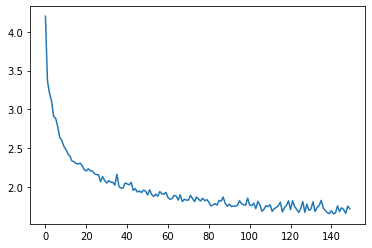

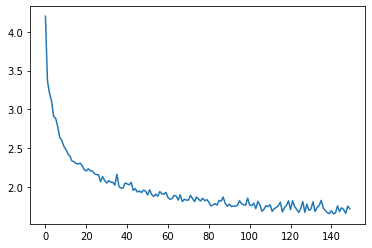

In [0]:
plt.figure()
plt.plot(record['loss'])
plt.show()

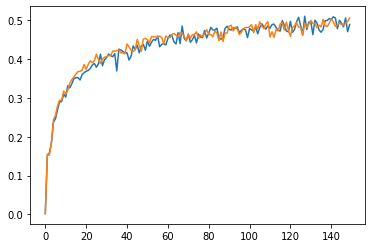

In [0]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [0]:
print(generate(model, device)) #default tau = 0.8

Julieter of this none to home, all
These fathenes: the such sore is to be but, by this Lord
With sent and more their will he see them.

HOLENCESTER:
Where t


In [0]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julieter the seen
The shall the shall be the shall be the seen
The shall the shall be the shall be the seen
The shall the shall be the shall be the seen
The 

julieto;
Seiklepow cUtelipure,
aleVchccaip-Mysence Uparny reson
ove-umvilad; for eutidie
Of:
FuRfanor.n O:YotF. Mow im, nerWur?s,
nUr'dnMbazen faJNhe?.
Sras 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i willy bring buch your lifes
That must yet send thy desing and seed,
To in father of mine gail and will stear;
As not moness'd him igning to-scomes
I know do this hope thou bean to them,
If home a play.

PRITAD:
Or the dour thousands a shall sains love,
As much in a morther to lude a home the Nadrry.

CPEEN:
See to that seard of mould to his speak and anaspant,
And in the will for thin that sever with mink we would would not
best undershall got for one her him heres,
Sisiling and bean so hanges his w 



In [0]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.49467140436172485

In [0]:
calc_accuracy(model, train_data, n_batch=len(test_data)-1, device=device)

0.5093761682510376

In [0]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
rr t tatioen:
Tu ore ti srovesd tnd torther  ae r te toeak


CNl 
Tieak  theak 

Cirst Satieen:
Iou sre t l tesenee  tether to tod thet th totenh


CNl 
Tetenee  
Ieaenees 

Cirst Satieen:
Iorst  tou 


In [0]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
rr t tatioen:
Tu ore ti srovesd tnd torther  ae r te toeak


CNl 
Tieak  theak 

Cirst Satieen:
Iou sre t l tesenee  tether to tod thet th totenh


CNl 
Tetenee  
Ieaenees 

Cirst Satieen:
Iorst  tou 


In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i willed his have make,
If the lies of sound thee, we lord me deer which
Have from the partion in is comed of the plaker.

MATUS IN:
Ay, I was thousunch a such on the lay lieds
That I walk for erty a celdinered and shall
Of an your charbot our weother upon in araw,
And sir; my lake the same dack the spoot,
And fifsed and his well innot. O sir:
And now nor him fains off of mine.

DOR INA VENCARET:
Had the lord an shall be part in a drown to give.

SOLWANCUS:
Play, may fother's upon this well destrest,
 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #honours

i willy are may thou thanked come my would
The come of Rippannow, I have the dring; for go the
goness and it to before for thy hath time,
I are a gost shall come in althed too,
They for a friend of fill the she them for I most
Abpeet prove they poop this am for that respery.
What he gentless this fire to think'd of your argitibely?

BENOTO:
What, there in a retions ary in thy more
I wear me o'er pound the moded aglishess
That how the come soldor this than look of poly and will.

Seand letory:
O, my ba 

